**1. 自回归语言模型：**
* 代表模型：ELMo/GPT1.0/GPT2.0/XLNet
* $max_{\theta} \ logp_{\theta}(x) = \sum_{t=1}^{T}log \ p_{\theta}(x_t|x_{<t})$

**2. 自编码语言模型：**
* 代表模型：BERT系列
* $max_{\theta} \ logp_{\theta}(\bar{x}|\hat{x}) \approx \sum_{t=1}^{T}log \ m_tp_{\theta}(x_t|\hat{x}) = \sum_{t=1}^{T}log \ m_tlog\frac{exp(H_{\theta}(\hat{x})_t^Te(x_t))}{\sum_{x'}exp(H_{\theta}(\hat{x})_t^Te(x'))}$

**3. BERT：双向 Transformer**（https://arxiv.org/pdf/1810.04805.pdf）
Bidirectional Encoder Representations from Transformers.

**4. 输入表示**
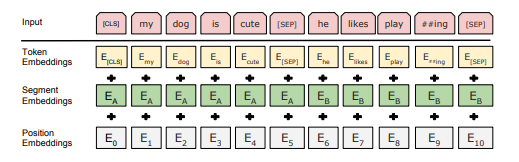

**5. 预训练任务**
* 5.1. Masked Language Modeling
* 5.2. Next Sentence Prediction
 
**6. 整合代码**

**7. 回忆**
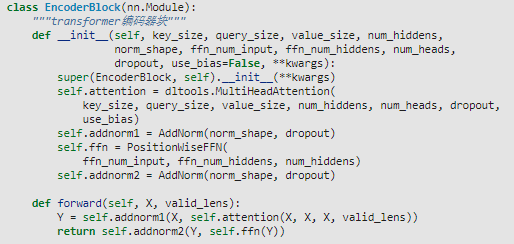


In [1]:
import torch
from torch import nn
import dltools

In [2]:
# 输入数据格式
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输入序列的词元及其片段索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记片段A和B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [3]:
get_tokens_and_segments([1,2,3],[4,5,6])

(['<cls>', 1, 2, 3, '<sep>', 4, 5, 6, '<sep>'], [0, 0, 0, 0, 0, 1, 1, 1, 1])

In [4]:
# BERT编码器
class BERTEncoder(nn.Module):
    """BERT编码器"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,**kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", dltools.EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
            ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [5]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,ffn_num_hiddens, num_heads, num_layers, dropout)

In [6]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [ ]:
# Masked Language Modeling
class MaskLM(nn.Module):
    """BERT的掩蔽语言模型任务"""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # 假设batch_size=2，num_pred_positions=3
        # 那么batch_idx是np.array（[0,0,0,1,1,1]）
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [ ]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

In [ ]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

In [ ]:
# Next Sentence Prediction
class NextSentencePred(nn.Module):
    """BERT的下一句预测任务"""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # X的形状：(batchsize,num_hiddens)
        return self.output(X)

In [ ]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输入形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

In [ ]:
encoded_X.shape

In [ ]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

In [ ]:
# 整合代码：
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None,pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 用于下一句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat